*Tim Boudreau <br>
tim.boudreau25@gmail.com* <br>
https://github.com/timboudreau25/
***

# Hit Prediction


Not every batted ball with quality contact becomes a hit. Likewise, neither does every poorly hit ball become an out. This project is to create a model that can predit whether or not a batted ball is a hit, based on numerous factors. A model like this, done right, can aid in the valuation of players. I believe tools like this can help discern true talent levels of players, discerning skill versus possible batted ball (mis)fortune.

I chose to analyze batted balls to predict whether or not a single batted ball would be a hit. The algorithm I thought bets to use was the random forest algorithm, because it allows multiple iterations as well as is proficient for classification.

##  Data Source:

Most of my data is from BaseballSavant (https://baseballsavant.mlb.com/about) and its Statcast search tool. I formed a SQL database of every pitch thrown and their outcomes between April and August 2017.

Each query from BaseballSavant returned approximately 30,000 pitches, which was about a week's worth of pitches. Appending these weeks took a while, so I created this database to swiftly import the data for use.

In [1]:
%matplotlib inline

from __future__ import division
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics
from IPython.display import Image
from IPython.display import HTML, display

/Users/Tim/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
## connect to database

path = 'Data/mlb_data.db'
conn = sqlite3.connect(path)
c = conn.cursor()


## execute query for pitch data

data_df = pd.read_sql("""SELECT batter, events, release_speed, 
	release_spin_rate, pfx_x, pfx_z, plate_x, plate_z, 
    home_team, stand, 
    p_throws, hc_x, hc_y, hit_distance_sc, launch_speed,
    launch_angle, inning_topbot, away_team, estimated_woba_using_speedangle as woba
	FROM MLB_2017
    WHERE bb_type != '123456789'
    AND events NOT IN ('sac_bunt')
    AND hit_distance_sc != '123456789'
	;""", conn)


## query for mlb batter key and set it as a dictionary

key = pd.read_sql("""SELECT mlb_id, mlb_name FROM ID_Key;""", conn)
c.close()

key = key.set_index('mlb_id')['mlb_name'].to_dict()

I selected many variables for this analysis: I selected many variables for this analysis: pitch release spin and speed, pitch movement (in horizontal and vertical directions), pitch location crossing home plate, hit location, hit distance, launch angle and launch speed, ballpark, pitcher and batter handedness and fielding team. Some of these I created in the next section.

## Data Preparation


I created some dummy variables and removed nulls from my data. After preparing the data, I created a copy of the dataset, as I drop the list of batters for the random forest regressions while I want to keep the batter list for batter analysis later.

To prepare the data for analysis, first I removed the null contents. In creating the SQL database, I labeled each null as 123456789. What was unique about BaseballSavant's dataset is that, instead of having a null cell, the datasets would have a string "null" instead. Using a large, unique integer allowed me to remove nulls with the confidence that the data points truly were null - no variable in this set should be even a tenth of 123456789, let alone match that. In the query I removed null batted ball types, which were pitches not put in play, and null hit distances, which were errors in data collection.

Beyond removing nulls, I created a boolean column classifying if a pitch resulted in a hit or not. Most of the null data I removed were null in hit metrics, as they were balls or strikes thrown. This was the leading factor in my decision to solely analyze balls in play. Of the remaining data, all were put in play. 

I also created a boolean for whether the inning of the pitch was the top or the bottom of the inning. I did this to create a fielding column, where the team fielding was a dummy in the analysis. 

In [11]:
## add a boolean column for whether or not the batted ball was a hit

hits = ['single', 'double', 'triple', 'home_run']

data_df['hits'] = (data_df['events'].isin(hits)).astype(int)


## map the batter key to the dataset to replace batter index with names

data_df['batter'] = data_df['batter'].map(key)


## create a column for the fielding team

def fielding_team(row):
    if row['inning_topbot'] == 'Bot':       # if it's the bottom of the inning, the away team fields
        return row['away_team']
    elif row['inning_topbot'] == 'Top':     # if it's the top of the inning, the home team fields
        return row['home_team']
    else:
        return"failed"


data_df['fielding'] = data_df.apply(lambda row: fielding_team(row), axis = 1)   # apply formula from above


## remove unecessary columns used in variable creation

del data_df['away_team']
del data_df['inning_topbot']
del data_df['events']


## rename columns we will create dummies from

data_df = data_df.rename(columns = {'home_team' : 'park', 'stand' : 'batter_hand',
                            'p_throws' : 'pitcher_hand'})


## convert strings to boolean integers

col_list = data_df.select_dtypes([np.object]).columns[1:]

data_df = pd.get_dummies(data_df, prefix = col_list, columns = col_list)


## create a copy dataframe, to later compare the outcomes of removing null outliers

data = data_df.copy()

## Potential Outliers

Considering outliers, I plotted the distribution of values for each numerical variable in the analysis. To save the space in this markdown, I plotted only the two variables who had outliers that I felt needed to be removed. 

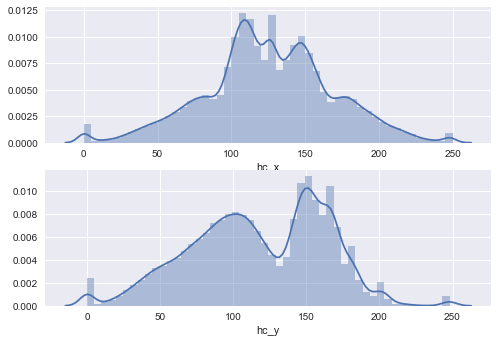

In [12]:
## print a distribution of values for every numerical variable to scan for outliers

# for col in data.columns:
#     if data[col].dtype in (np.float64, np.int64):
#         sns.distplot(data[col])
#         plt.show()
#     else:
#         continue

plt.subplot(2,1,1)
sns.distplot(data['hc_x'])

plt.subplot(2,1,2)
sns.distplot(data['hc_y'])


I discovered these outliers while plotting the hit locations in Tableau. The hit x and hit y coordinates both have noticable occurances at 0 and 240. I'm unsure of the units in this dataset - I'm unable to find a directory - but it was clear these points were mistakes, likely produced as nulls by the tools that acquired the data.

In [26]:
## remove the outliers - the max and min values seen in the distributions above

data = data[(data['hc_y'] > 0) & (data['hc_y'] < 248)
        & (data['hc_x'] > 0) & (data['hc_x'] < 248)]


## print the percentage of batted balls that are hits with and without the removed values

print "Percent of batted balls as hits - original data: ", round(sum(data_df['hits']) / len(data_df), 3)
print "Percent of batted balls as hits - after removing outliers: ", round(sum(data['hits']) / len(data), 3), "\n"

Percent of batted balls as hits - original data:  0.355
Percent of batted balls as hits - after removing outliers:  0.356 



After removing unexpected outliers, the percentage of batted balls that were hit remained essentially unchanged. This implies that the outliers has no significant affect on the distribution of hits. I still chose to remove them, though, to clean the data further. The lack of change likely ould be due to the small amount of broken outliers.

## Modeling

### Model Preparation

To prepare the clean data for modeling, I ignored the batter list from the dataset I used to model. Rather than remove the batters directly, I copied the dataset and then removed the batters. Later, I want to use the batters in evaluating the model on a small sample. Beyond removing the batters, I created a hit key to label the boolean zeroes and ones that represent hits and outs. After building the model, I will use this key to map hits and outs for clarity in output display.

In [27]:
variables = data.columns[data.columns != "hits"][1:]

hit_key = {}

hit_key = pd.DataFrame( {'string' : ['hit', 'out'],
                   'integer' : [1, 0]}).set_index('integer')['string'].T.to_dict()

In [28]:
# create a random forest classifier with two iterations

clf = RandomForestClassifier(n_jobs=2)

In [29]:
scores = cross_val_score(clf, data[variables], data['hits'], cv=5)
print "Cross-validated scores:", scores

Cross-validated scores: [ 0.86302424  0.89578409  0.89329888  0.90148975  0.90561267]


I chose to run the random forest classifier with two iterations because of the time saved running two evrsus, say, ten and because the model didn't improve with more iterations. To properly build the model, I chose to cross-validate five times. As seen with the cross-validation scores, the model improved with further training. The score is an arbitrary mark, derived from the Mean Squared Error and parameter defining, that implies the quality of the model. A higher score implies a stronger model fit. Using cross validation to train the model increased the quality of it.

### Random Forest Modeling

Below, I created a dataframe with the results of our prediction and the actual hit/out classification of each ball in play. I printed out a confusion matrix, which reflects on the correct and incorrect classifications by the model on the actual data.

In [30]:
results = pd.DataFrame({'prediction' : cross_val_predict(clf, data[variables], data['hits'], cv=5),
                     "actual" : data['hits']}).applymap(hit_key.get)

pd.crosstab(results.actual, results.prediction)
# .apply(lambda r: (r/r.sum() * 100).astype(float).round(6), axis=1)

prediction,hit,out
actual,,
hit,25490,6862
out,2980,55627


In [31]:
pd.crosstab(results.actual, results.prediction).apply(lambda r: (r/r.sum() * 100).astype(float).round(4), axis=1)

prediction,hit,out
actual,,
hit,78.7896,21.2104
out,5.0847,94.9153


The first confusion matrix is the numerical amount of correct and incorrect predictions. The seocnd confusion matrix is the percent of correct and incorrect classifications. For example, in these confusion matrices, the top-right quadrant is the count (or percentge) of actual hits the model predicted as outs.

In [32]:
data['prediction'] = (results['prediction'] == "hit").astype(int)


# results['false_positives'] = results['prediction'] - results['actual']
# results['false_negatives'] = results['act']

# print results['false_positives']
# print results['false_negatives']


print "\nPercent of batted balls as hits - predicted hits: ", round(sum(data['prediction']) / len(data), 3)

print "Percent of batted balls as hits - original data: ", round(sum(data['hits']) / len(data), 3)


Percent of batted balls as hits - predicted hits:  0.313
Percent of batted balls as hits - original data:  0.356


As above, the data's percentage of batted balls that are hits is 35.6%. The predicted percentage, however, is lower, close to 31.5% (may slightly change if kernel isn't set and program is rerun). Prior to removing data points with null hit distances, the original percentage was closer to 33%. Further investigation is needed in why there is a discrepency between the model and actual, but I believe this could be due to the lack of fielder position data, which significantly impacts hit outcomes, or it could be the model struggling to depict, in the infield, fielder-induced hits, such as poor routes to balls, or well-placed balls.

In [33]:
def same(row):
    if row['hits'] == row['prediction']:
        value = 1
    else:
        value = 0
    return value

data['correct'] = data.apply(same, axis=1)

I created a column called "correct" that is true when the prediction was correct and false when it was incorrect. I used this for plotting in Tableau.

## Batter Analysis

I thought it would be interesting to apply this model to batters. Being able to predict a batter's potential hit count is my goal. I don't expect the results to be significant, though, as the sample sizes are a bit small (below 500 occurances per batter). 

### Data Preparation

To analyze hit prediction for each batter, I had to group the data by batter. To enhance the quality of my analysis, I limited the batters to those with more than 100 batted balls. I stored prediction values and actual values for hits in a dataframe, and use a formula to detemrine whether it is a false positive or negative.

In [34]:
## group the data by batter and create a count variable to limit sample to batters with more than 100 batted balls

data['count'] = data.groupby('batter')['batter'].transform('count')

batter_data = data[data['count'] > 100]


## create a list of batters. commented out is a short list for quick use

batter_list = batter_data['batter'].unique()
# batter_list = ['Brandon Crawford', "Buster Posey", "Denard Span"]


## define the columns in the dataframe that will collect batter prediction results

cols = [['batter', 'false positives', 'false negatives', 'correct']]

result_list = pd.DataFrame([])


## define a function that classifies a wrong prediction as a false negative or positive

def false_check(row):
    if (row['prediction'] is "hit") & (row['actual'] is "out"):   
        return "False Positive"
    elif (row['actual'] is "hit") & (row['prediction'] is "out"): 
        return "False Negative"
    else:
        return "Correct"

The loop through the batters took longer than expected, close to 10 minutes on my machine. For sake of speed, I created a list of three batter that I use to test the code, but I ran through the entire list of batters for this markdown. The for loop runs through each batter, breaks the dataframe down into their batted balls and predicts for each batted ball if it is a hit. I then stored those values in a dataframe, label the 1's as hits and 0's as outs, create false positives and negatives and repeat for every batter. I also created a percentage correct/false positive/negative.

In [35]:
## loop through eveyr batter in our list to calculate predicted hits and the errors

for batter in batter_list:
    
    
    ## create a subset of data where each batted ball is by our batter
    
    data_batter = data[data['batter'] == batter]

    
    ## predict the batted ball hit outcomes and store it alongside actual hit outcomes,
    ## mapping hit and out to 1 and 0
    
    batter_results = pd.DataFrame({'prediction' : cross_val_predict(clf, data_batter[variables], data_batter['hits'], cv=5),
                     "actual" : data_batter['hits']}).applymap(hit_key.get)


    ## calling the above function, classify each prediction by type of error or correct
    
    batter_results['type'] = batter_results.apply(lambda row: false_check(row), axis = 1)   # apply formula from above

    
    ## count the total amount of errors by type, and correct
    
    false_positive = sum(batter_results['type'].str.count("False Positive"))
    false_negative = sum(batter_results['type'].str.count("False Negative"))
    correct = sum(batter_results['type'].str.count("Correct"))
    
    
    ## store the error counts and correct count in a dataframe, by batter
    
    result_list = result_list.append(pd.DataFrame({ "batter" : batter,
                                                    "false_positive" : false_positive,
                                                    "false_negative" : false_negative,
                                                    "correct" : correct}, index = [0]), ignore_index = True)


## find the pcerentage of each error and correct for each batter

result_list['percent_correct'] = result_list['correct']/result_list.sum(axis = 1)
result_list['percent_false_pos'] = result_list['false_positive']/result_list.sum(axis = 1)
result_list['percent_false_neg'] = result_list['false_negative']/result_list.sum(axis = 1)

In [36]:
## print the top 8 correct and bottom 8 incorrect predicted batters

print result_list.nlargest(8, 'percent_correct')[['batter', 'percent_correct']]
print "\n", result_list.nsmallest(8, 'percent_correct')[['batter', 'percent_correct']]

                batter  percent_correct
181  Giancarlo Stanton         0.878689
128      Albert Pujols         0.876712
59           Josh Bell         0.875389
7         Matt Wieters         0.872510
151        Mike Napoli         0.867580
291     Chris Iannetta         0.866667
201        Eric Thames         0.860169
203       Kole Calhoun         0.858521

              batter  percent_correct
330       Adam Engel         0.657895
275   Alexi Amarista         0.692308
76   Adrian Gonzalez         0.700637
338    Nick Williams         0.703125
267       Alex Avila         0.704403
169   Pablo Sandoval         0.710280
156  Jonathan Villar         0.714976
335      Jose Pirela         0.715000


I haven't been able to determine a characteristic or multiple that impact batters being on the top prediction list or bottom. My initial theory was that slower batters would be predicted better, as they have a much lower chance of getting an infield hit (which, as seen later, is one area where the model struggles). Another theory I had was that extreme pull or push hitters, who are easier to shift on, would be better predicted. Browsing the top 8 lists, though, nothing stood out. There are slow batters on the bottom as well as a few pull hitters. This is something I want to further research, with batter-specific data like speed scores, spray charts, etc.

In [37]:
## export data to csv to use in Tableau

data.to_csv("prediction.csv", sep = ",")

Lastly, I exported the data to a csv file to grachically display in Tableau.

## Model Evaluation & Results

Below are graphs evaluating the performance of the model. In summary, I believe the model is accurate in many areas and struggles where one would expect it to struggle, such as in the infield with weaker contact.

I plotted these graphs in Tableau. The dark blue points are hits and the light blue points are outs. Red points are false positives and negatives.

In [8]:
display(HTML("<center><table><tr><td><img src='Images/Launch Speed vs Launch Angle, Actual.png' alt='Drawing' style='width: 1000px;'/></td><td><img src='Images/Launch Speed vs Launch Angle, Predictions.png' alt='Drawing' style='width: 1000px;'/></td></tr></table></center>"))

,


This graphic plots launch speed against launch angle. As seen here and in many datasets, there are areas where the batted balls have an extremely high probability of hits. Comparing the plots of actual hit classifications to the predicted hit classifications reveals areas in which the model performed poorly - namely, low launch angle and low exit velocity. 

In [7]:
display(HTML("<center><td><img src='Images/Launch Speed vs Launch Angle, Actual wOBA.png' alt='Drawing' style='width: 500px;'/></td></tr></center>"))

Compare this chart to the ones above it. This is a chart of exit velocity versus launch angle, like above, but colored by weighted on-base-average (wOBA). The darker the blue, the higher wOBA, with orange being a below league-average wOBA.

As a refresher, wOBA is an all-encompassing offensive measure used to evaluate overall offensive performance per plate appearance, using linear weights on all potential batter outcomes. It is similar to batting average, on base percentage, slugging percentage and OPS as it tries to quantitatively value outcomes of at bats, however wOBA weighs each outcome based on the impact on run scoring (the run value of certain events). The league average wOBA is .320, where an excellent wOBA is anything above .400. The dark blue area, for context, is reaches a wOBA of 1.985! 

Notice that the actual and predicted hits fall in the same exit velocity - launch angle belt as high wOBA values. The model does well at predicting hits, which directly impact wOBA. The model struggles where factors outside our model, such as batter speed and fielder location, impact the outcome of a hit. This model is a pitch-based and batted-ball-based model, for now.

In [6]:
display(HTML("<center><table><tr><td><img src='Images/Launch Speed vs Launch Angle, False Positives.png' alt='Drawing' style='width: 1000px;'/></td><td><img src='Images/Launch Speed vs Launch Angle, False Negatives.png' alt='Drawing' style='width: 1000px;'/></td></tr></table></center>"))

,


These plots are of where the model incorrectly classified batted balls. They both have the same axes as above, launch distance versus launch angle. On the left is where there were false positives i.e. the model classified a hit where it was an out, while on the right are false negatives, where an out was classified as a hit.

Most of the false positives were along the periphery of the hit belt seen above, which is to be expected. Almost every batted ball with those launch angles and exit velocities was a hit.

Many of the false negatives were in two general areas - as weak ground balls, where the hit classifications are influenced by fielding and batter speed, and as hits along the hit belt. The sheer amount of batted balls along the hit belt could be why there are many misclassifications there. Beyond that, batted balls along the edge of the hit belt may fall for hits on occasion, but are more similar to outs than hits.

In [5]:
display(HTML("<center><table><tr><td><img src='Images/Actual Hits and Outs, Field View.png' alt='Drawing' style='width: 1000px;'/></td><td><img src='Images/Predicted Hits and Outs, Field View.png' alt='Drawing' style='width: 1000px;'/></td></tr></table></center>"))

,


Each batted ball is plotted, with dark points as hits (or projected hits) and lighter points as outs. It's clear where there are hits, as they are where one would expect hits (and predicted hits) to be. Howver, there are two significant areas of misclassification that stand out to me - the infield and the outfield gaps.

Infield batted balls are almost completely projected to be outs, while there are a noticable amount of infield hits in actual. This is the main driver behind the inaccuracy of the model. Knowing batter speed and fielder positioning would help increase this accuracy. Batter speed is important because many quick runners can beat out softly-hit grounders. Fielder position is relevant as well because it isn't currently known where the fielders are located for each batted ball. If there is a large shift on a left handed batter, for example, a soft dribbler down the third base line may be an easy hit, but this model would assume it to be a routine grounder to the third baseman.

Gap hits are difficult to predict because, again, fielder positioning is unknown. A typical outfield shift places an outfielder (or two!) in the middle of the gaps. Knowing those fielding locations would allow for more descriptive regression models in this random forest to predict batted ball outcomes. Beyond fielding location data, individual fielder data would potentially allow for accuracy increases in prediction. Fielder speeds, route efficiencies and initial starting positions, whether encompassed in defensive runs saved (DRS) or ultimate zone rating (UZR) or as individual metrics, would further explain outcomes of batted balls and increase predictive capabilities of the model.

## Conclusion

Hits are simultaneously easy and difficult to predict. Given pitch characteristics and batted ball information, my model predicted 75%+ of the hits and 94%+ of outs correctly. The gaps in actual versus predicted could be shrunk with fielder data, such as positioning, speed, route efficiencies, etc., and with batter information, such as batter speed. As seen in the graphics, the majority of the false predictions were in two general locations, where deeper fielder and batter information could greatly impact the model's performance. Without that information, it is difficult to characterize why some batters were predicted well and others poorly. 


### Next Steps
- Include batter information and fielder information in the model.
- Gather batter statistics to find trends in batter prediction abilities.
- Consider removing gap and infield batted balls to evaluate efficiency elsewhere.